### Visualizing the history of the ebola Epidemic

**Note** : 
Analyzing the spread of Ebola. The outbreak has been contained now, nonetheless we will analyze the history of the spread for the 3 of the countries found below. 


The data is available in [this site](http://apps.who.int/gho/data/view.ebola-sitrep.ebola-summary-latest?lang=en) and they provie a restful api to download the data in csv formats. you can download up to date data about the ebola epidemic. We will download the numbers pertaining to cumulative cases and cumulative deaths for the dates as given in the question and generate graphs to visualize them.

In [1]:
# The URL through which the data can be gotten is the following
# The %s indicates the place where the date should be inserted, in a format such as: "2014-11-20"

base_url='http://apps.who.int/gho/athena/xmart/data-verbose.csv?'+\
    'target=EBOLA_MEASURE/CASES,DEATHS&profile=verbose&'+\
    'filter=COUNTRY:GIN;COUNTRY:UNSPECIFIED;COUNTRY:LBR;COUNTRY:UNSPECIFIED;'+\
    'COUNTRY:SLE;COUNTRY:UNSPECIFIED;LOCATION:-;'+\
    'DATAPACKAGEID:{0};INDICATOR_TYPE:SITREP_CUMULATIVE;'+\
    'INDICATOR_TYPE:SITREP_CUMULATIVE_21_DAYS;'

In [2]:
# Use requests.get and pandas to create a list of dataframes, one for each date.
# Dates for which the downloaded file is less than 1000 byte are ignored (because they contain no data)

import pandas as pd
import numpy as np
import requests
from datetime import date, timedelta as td

d1 = date(2014,11,1)
d2 = date(2014,12,5)
delta = d2 - d1

DF={}
for i in range(delta.days + 1):
    D=str(d1 + td(days=i))
    url=base_url.format(D) #define the URL from which to download the data
    csv=requests.get(url) # Download the data into csv using request.get
    if len(csv.content) > 1000:
        print '"%s"'%D,len(csv.content),
        DF[D]=pd.DataFrame.from_csv(url)
        print DF[D].shape

"2014-11-12" 9369 (36, 22)
"2014-11-14" 8578 (24, 22)
"2014-11-19" 9466 (36, 22)
"2014-11-21" 8118 (24, 22)
"2014-11-26" 9829 (36, 22)
"2014-11-28" 5773 (24, 22)
"2014-12-01" 5929 (24, 22)
"2014-12-02" 5737 (24, 22)
"2014-12-03" 9702 (39, 22)
"2014-12-04" 6239 (26, 22)
"2014-12-05" 6231 (26, 22)


In [3]:
# list the names of the columns for "2014-11-12"
DF['2014-11-12'].columns.tolist()

['COUNTRY (DISPLAY)',
 'COUNTRY (URL)',
 'EBOLA_MEASURE (CODE)',
 'EBOLA_MEASURE (DISPLAY)',
 'EBOLA_MEASURE (URL)',
 'CASE_DEFINITION (CODE)',
 'CASE_DEFINITION (DISPLAY)',
 'CASE_DEFINITION (URL)',
 'EPI_WEEK (CODE)',
 'EPI_WEEK (DISPLAY)',
 'EPI_WEEK (URL)',
 'INDICATOR_TYPE (CODE)',
 'INDICATOR_TYPE (DISPLAY)',
 'INDICATOR_TYPE (URL)',
 'DATAPACKAGEID (CODE)',
 'DATAPACKAGEID (DISPLAY)',
 'DATAPACKAGEID (URL)',
 'Display Value',
 'Numeric',
 'Low',
 'High',
 'Comments']

In [4]:
# merge the dataframes in DF into a single dataframe called DF_combined
# Find the names of the columns that are common to all of the dataframes.
# Restrict the data frames to the rows where the measurements have been 
# cumulative (rather than for the last 21 days) and that the number is confirmed 
# (rather than estimated or probable)

Cols = None
DF_Combined=pd.DataFrame()
for k in DF.keys():
    C=set(DF[k].columns.tolist())
    if 'EPI_WEEK (CODE)' in C:
        DF[k].rename(columns={
                'EPI_WEEK (CODE)'   : 'EPI_DATE (CODE)', 
                'EPI_WEEK (DISPLAY)': 'EPI_DATE (DISPLAY)',
                'EPI_WEEK (URL)'    : 'EPI_DATE (URL)' 
                }, inplace=True)
    if Cols==None:
        Cols=C
    else:
        Cols=Cols & C
        
Cols = list(Cols)
        
for k in DF.keys():   
    df=DF[k][list(Cols)]
    df=df[df["INDICATOR_TYPE (DISPLAY)"]=="Cumulative"]        
    df=df[df["CASE_DEFINITION (DISPLAY)"]=="Confirmed"]       
    DF_Combined = pd.concat([DF_Combined,df[Cols]])
    print k, DF_Combined.shape

print Cols

2014-11-14 (6, 19)
2014-11-21 (12, 19)
2014-11-12 (18, 19)
2014-11-26 (24, 19)
2014-12-02 (30, 19)
2014-11-28 (36, 19)
2014-12-01 (42, 19)
2014-11-19 (48, 19)
2014-12-04 (54, 19)
2014-12-05 (60, 19)
2014-12-03 (66, 19)
['EBOLA_MEASURE (DISPLAY)', 'CASE_DEFINITION (URL)', 'INDICATOR_TYPE (CODE)', 'DATAPACKAGEID (URL)', 'INDICATOR_TYPE (DISPLAY)', 'CASE_DEFINITION (DISPLAY)', 'EBOLA_MEASURE (URL)', 'Display Value', 'Comments', 'High', 'Low', 'INDICATOR_TYPE (URL)', 'DATAPACKAGEID (CODE)', 'EBOLA_MEASURE (CODE)', 'DATAPACKAGEID (DISPLAY)', 'COUNTRY (DISPLAY)', 'Numeric', 'CASE_DEFINITION (CODE)', 'COUNTRY (URL)']


In [5]:
# cols contains all of the columns we need in DF_Combined
cols=['COUNTRY (DISPLAY)',
 'EBOLA_MEASURE (DISPLAY)',
 'DATAPACKAGEID (CODE)',
 'Numeric']
print cols

['COUNTRY (DISPLAY)', 'EBOLA_MEASURE (DISPLAY)', 'DATAPACKAGEID (CODE)', 'Numeric']


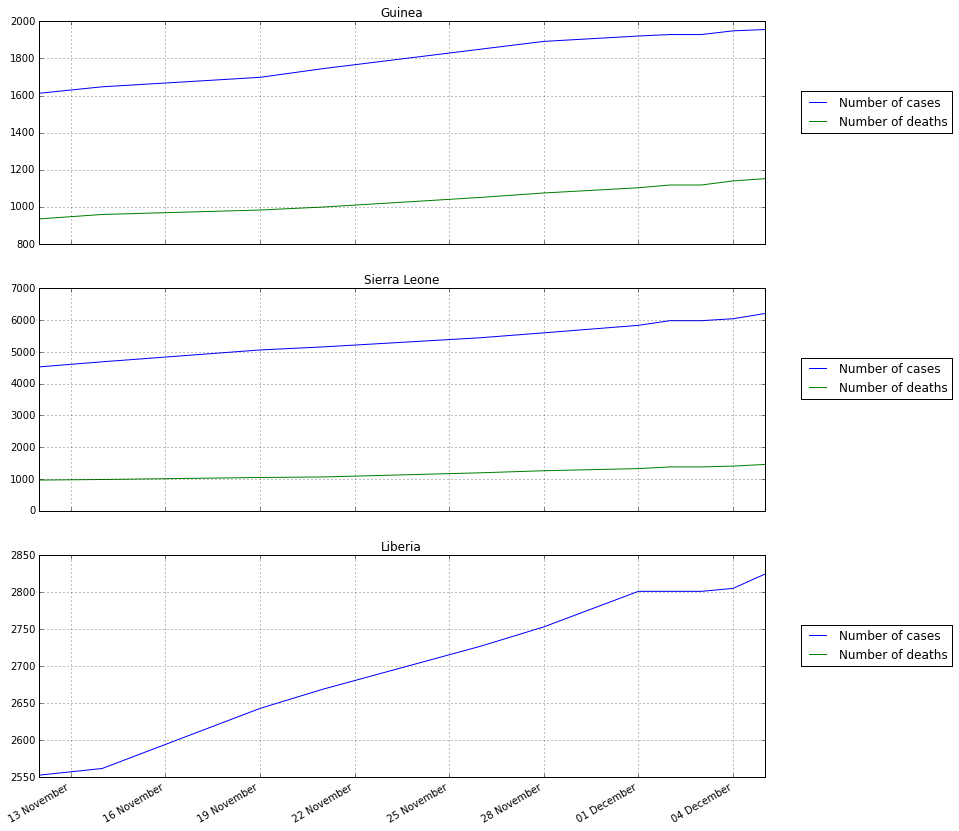

In [8]:
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d %B')

dff=DF_Combined[cols]
dff=dff.sort(columns=['COUNTRY (DISPLAY)','EBOLA_MEASURE (DISPLAY)','DATAPACKAGEID (CODE)'])
dff = dff.set_index(pd.to_datetime(dff['DATAPACKAGEID (CODE)'], format='%Y-%m-%d'))
Countries=set(dff['COUNTRY (DISPLAY)'])
types=set(dff['EBOLA_MEASURE (DISPLAY)'])

fig, axarr = plt.subplots(3,sharex=True)
fig.set_size_inches((13,15)) 
fig.autofmt_xdate()

def onpick(event):
    thisline = event.artist
    xdata = thisline.get_xdata()
    ydata = thisline.get_ydata()
    ind = event.ind
    print 'onpick points:', zip(xdata[ind], ydata[ind])

fig.canvas.mpl_connect('pick_event', onpick)


i=0
for C in Countries:
    legend_list = []
    for t in types:
        data=dff[(dff['COUNTRY (DISPLAY)']==C)&(dff['EBOLA_MEASURE (DISPLAY)']==t)]
        data['Numeric'].plot(ax = axarr[i])
        axarr[i].set_title(C)
        axarr[i].set_xlabel('')
        legend_list.append(t)
    axarr[i].xaxis.set_major_formatter(myFmt)
    axarr[i].legend(legend_list, loc=(1.05,0.5))
    axarr[i].grid()
    i+=1

show()